# Install necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load preprocessed event data

In [ ]:
import gdown

file_id = "1VowGO9LARBtqE5pec3QsaDdruhGTER-J"
output = "processed_events.csv"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

df = pd.read_csv(output)

Downloading...
From (original): https://drive.google.com/uc?id=1VowGO9LARBtqE5pec3QsaDdruhGTER-J
From (redirected): https://drive.google.com/uc?id=1VowGO9LARBtqE5pec3QsaDdruhGTER-J&confirm=t&uuid=92d258e7-aa6c-46d8-b400-5c0dbb5dbee2
To: /content/processed_events.csv
100%|██████████| 335M/335M [00:06<00:00, 54.7MB/s]


# Aggregate user behavior
Aggregate by visitorid to count views, add-to-carts, and transactions

In [ ]:
user_behavior = df.groupby('visitorid').agg(
    total_views=('event', lambda x: (x == 'view').sum()),
    total_addtocart=('event', lambda x: (x == 'addtocart').sum()),
    total_purchases=('event', lambda x: (x == 'transaction').sum())
).reset_index()

#Heatmap of Event Correlations
To visualize which behaviors are most correlated (e.g., do more views lead to more purchases?),
to indicate where to focus marketing or UX improvements.

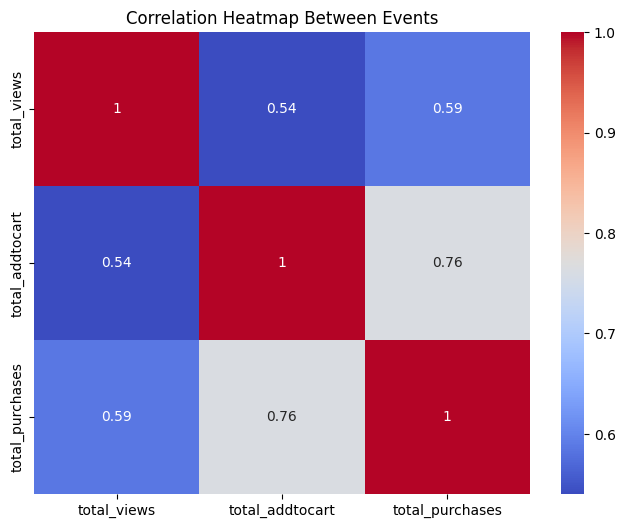

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(user_behavior[['total_views', 'total_addtocart', 'total_purchases']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap Between Events")
plt.show()

# Standardize features

normalize the numerical features

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(user_behavior[['total_views', 'total_addtocart', 'total_purchases']])

# Determine optimal clusters using Elbow Method

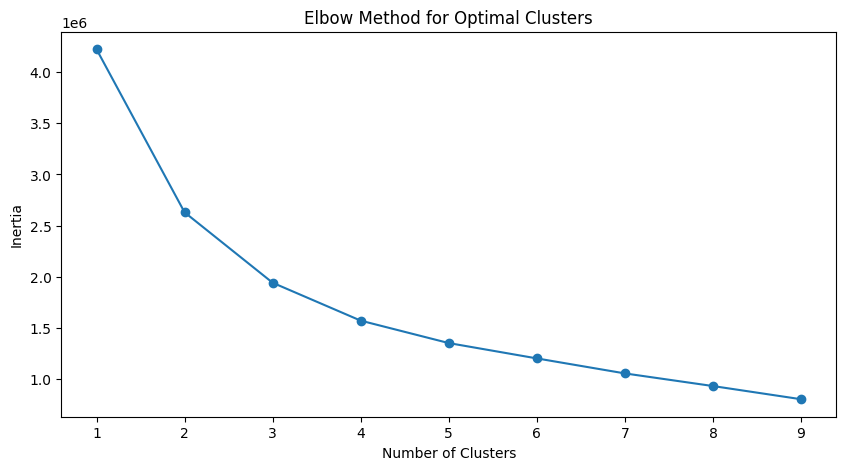

In [ ]:
inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

appply silhouette score

# Apply K-Means Clustering

In [ ]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
user_behavior['cluster'] = kmeans.fit_predict(scaled_features)

# Interpret Clusters

In [ ]:
cluster_summary = user_behavior.groupby('cluster').mean()
print("Cluster Characteristics:")
print(cluster_summary)

Cluster Characteristics:
             visitorid  total_views  total_addtocart  total_purchases
cluster                                                              
0        703792.429844     3.949989         0.096079         0.024963
1        636314.877193  2188.561404       208.543860       118.017544
2        611202.666667  7281.000000       912.333333       754.666667


# Visualize Clusters
3D Scatterplot

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


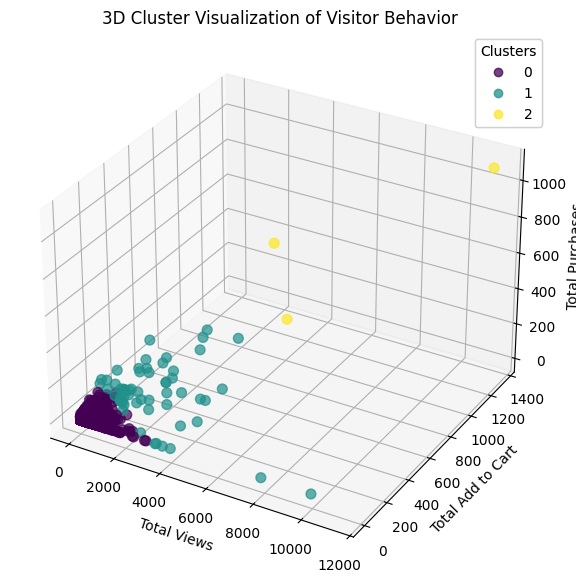

In [ ]:
cluster_names = {
    0: "Browsers",
    1: "Cart Abandoners",
    2: "Buyers"
}
user_behavior["cluster_label"] = user_behavior["cluster"].map(cluster_names)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    user_behavior["total_views"],
    user_behavior["total_addtocart"],
    user_behavior["total_purchases"],
    c=user_behavior["cluster"], cmap='viridis', s=50, alpha=0.7
)
ax.set_xlabel("Total Views")
ax.set_ylabel("Total Add to Cart")
ax.set_zlabel("Total Purchases")
plt.title("3D Cluster Visualization of Visitor Behavior")
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.show()

#Ratio Analysis (Conversion Rates)

In [ ]:
conversion_rates = user_behavior.groupby('cluster_label').agg({
    'total_views': 'sum',
    'total_addtocart': 'sum',
    'total_purchases': 'sum'
})

conversion_rates['view_to_cart'] = conversion_rates['total_addtocart'] / conversion_rates['total_views']
conversion_rates['cart_to_purchase'] = conversion_rates['total_purchases'] / conversion_rates['total_addtocart']
conversion_rates['view_to_purchase'] = conversion_rates['total_purchases'] / conversion_rates['total_views']

print(conversion_rates[['view_to_cart', 'cart_to_purchase', 'view_to_purchase']])

                 view_to_cart  cart_to_purchase  view_to_purchase
cluster_label                                                    
Browsers             0.024324          0.259818          0.006320
Buyers               0.125303          0.827183          0.103649
Cart Abandoners      0.095288          0.565912          0.053925


# Recommendations



In [ ]:
recommendations = {
    "Browsers": "Send discount coupons to encourage engagement.",
    "Cart Abandoners": "Offer free delivery or discounts to reduce cart abandonment.",
    "Buyers": "Reward with loyalty points to encourage repeat purchases."
}

for cluster, advice in recommendations.items():
    print(f"{cluster}: {advice}")

Browsers: Send discount coupons to encourage engagement.
Cart Abandoners: Offer free delivery or discounts to reduce cart abandonment.
Buyers: Reward with loyalty points to encourage repeat purchases.


# Save segmented user data

In [ ]:
user_behavior.to_csv('user_segments.csv', index=False)